In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
#from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, \
    average_precision_score
from sklearn.model_selection import train_test_split
import time
import os
from pathlib import Path
from skimage import io
import copy
from torch import optim, cuda
import pandas as pd
import glob
from collections import Counter
# Useful for examining network
from functools import reduce
from operator import __add__
# from torchsummary import summary
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from PIL import Image
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import gc
from scipy import stats

In [2]:
import pickle
from os import path
data_filename = "loaders.data"

if path.exists(data_filename):
    with open(data_filename, 'rb') as f:
        train_loader, test_loader = pickle.load(f)
else:
    train_df_available = pd.read_csv('/data/ECGnet/data/train_df_pace_removed_any_patient_negative_available_DEIDENTIFIED.csv')
    eval_df_available = pd.read_csv('/data/ECGnet/data/eval_df_pace_removed_any_patient_negative_available_DEIDENTIFIED.csv')

    fpath_train = "/data/ECGnet/data/amyloid_concat_train_pace_removed_any_patient_negative.npy"
    fpath_eval = "/data/ECGnet/data/amyloid_concat_eval_pace_removed_any_patient_negative.npy"

    trainData = np.load(fpath_train)  # Load input data. Input data should be compiled as numpy arrays with (sample numbers, time, lead, 1)
    evalData = np.load(fpath_eval)

    trainData = np.array(trainData)
    evalData = np.array(evalData)
    print('trainData initial shape:', trainData.shape)
    print('evalData initial shape:', evalData.shape)

    y_train = [round(x) for x in train_df_available['ANY_AMYLOID']]
    label_train = np.array(y_train)

    y_test = [round(x) for x in eval_df_available['ANY_AMYLOID']]
    label_eval = np.array(y_test)

    trainData = np.transpose(trainData, axes=[0, 2, 1, 3])
    evalData = np.transpose(evalData, axes=[0, 2, 1, 3])
    print('trainData norm_prep shape:', trainData.shape)
    assert trainData.shape[1:] == (12, 2500, 1), "train is not X,12,2500"
    assert evalData.shape[1:] == (12, 2500, 1), "eval is not X,12,2500"
    mean_tr, std_tr = np.mean(trainData, axis=(0,2,3)), np.std(trainData, axis=(0,2,3))

    def truncate_data_median(source_array, target_array):
        median = np.median(source_array)
        mad = stats.median_absolute_deviation(source_array)
        datamadlimit = target_array
        #Truncate data to 3*mad to limit outlier effect and use robust statistical approach over mean
        datamadlimit = np.where(datamadlimit > median + (3*mad), median + (3*mad), datamadlimit)
        datamadlimit = np.where(datamadlimit < median - (3*mad), median - (3*mad), datamadlimit)
        # datanorm2 = cv2.normalize(datamadlimit, datamadlimit, -1, 1, cv2.NORM_MINMAX)
        return datamadlimit

    evalData = truncate_data_median(trainData, evalData)
    trainData = truncate_data_median(trainData, trainData)

    med_tr, mad_tr = np.median(trainData, axis=(0,2,3)), stats.median_absolute_deviation(trainData, axis=(0,2,3))
    print(trainData.shape, med_tr.shape, mad_tr.shape)
    for i in range(trainData.shape[1]):
        trainData[:,i,:,:] = (trainData[:,i,:,:] - med_tr[i]) / mad_tr[i]
        evalData[:,i,:,:] = (evalData[:,i,:,:] - med_tr[i]) / mad_tr[i]

    mean_norm, std_norm  = np.mean(trainData, axis=(0,2,3)), np.std(trainData, axis=(0,2,3))
    print("Mean and STD after normalization", mean_norm, std_norm)
    med_norm, mad_norm  = np.median(trainData, axis=(0,2,3)), stats.median_absolute_deviation(trainData, axis=(0,2,3))
    print("Median and MAD after normalization", mean_norm, std_norm)

    trainData = np.transpose(trainData, axes=[0, 3, 2, 1])
    print('trainData shape for model:', trainData.shape)
    evalData = np.transpose(evalData, axes=[0, 3, 2, 1])
    print('evalData shape for model:', evalData.shape)

    assert trainData.shape[1:] == (1, 2500, 12), "train is not X,12,2500"
    assert evalData.shape[1:] == (1, 2500, 12), "eval is not X,12,2500"

    # def normalize_array(x):
    #     xmax, xmin = x.max(), x.min()
    #     return (x - xmin) / (xmax - xmin)

    # print("eval sum/mean before norm: ", evalData.sum(),evalData.mean())
    # evalData = normalize_array(evalData)
    # print("eval sum/mean after norm: ", evalData.sum(),evalData.mean())

    # print("train sum/mean before norm: ", trainData.sum(), trainData.mean())
    # trainData = normalize_array(trainData)
    # print("train sum/mean after norm: ", trainData.sum(), trainData.mean())

    # Change the place holder names
    X_train = np.array(trainData)
    X_test = np.array(evalData)
    y_train = label_train
    y_test = label_eval

    SHAPE = (-1, 12, 2500)  # Shape of the input. ECG model takes 2500 points sampled at 4 micro-seconds/point for 12 lead.
    batch_size = 64
    dlen = X_train.shape[0]

    y_test = torch.FloatTensor(y_test)
    X_test = TensorDataset(torch.from_numpy(X_test).reshape(SHAPE), y_test)
    test_loader = DataLoader(X_test, batch_size=batch_size, pin_memory=True, shuffle=True)
    # a,b=next(iter(test_loader))

    y_train = torch.FloatTensor(y_train)
    X_train = TensorDataset(torch.from_numpy(X_train).reshape(SHAPE), y_train)
    train_loader = DataLoader(X_train, batch_size=batch_size, pin_memory=True, shuffle=True)
    
    with open(data_filename, 'wb') as f:
        pickle.dump((train_loader, test_loader), f)

In [3]:
try:
    del model
    gc.collect()
    torch.cuda.empty_cache()
except:
    pass

In [4]:
from CRNN import CRNN
model = CRNN(hidR = 128 * 2, layerR = 1, hidC = 128 * 2)
# print(model)

In [5]:
sum(p.numel() for p in model.parameters())

514561

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f'Train on: {device}')
# send model to device
model.to(device)

CRNN(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(5, 12), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (GRU1): GRU(256, 256)
  (fc1): Sequential(
    (0): Flatten()
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=32, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [6]:
def update_outputs(output_dict,
                   new_outputs,
                   outputs_to_update=['scores', 'predictions', 'labels']):
    for x in outputs_to_update:
        if (type(new_outputs[x]) is list):
            output_dict[x] += list(new_outputs[x])
        else:
            output_dict[x].append(new_outputs[x])
    return output_dict

def accuracyFromLogits(output, target):
    scores = torch.sigmoid(output)
    pred = torch.round(scores)
    correct_tensor = pred.eq(target.data.view_as(pred))
    # Need to convert correct tensor from int to float to average
    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
    return accuracy, scores, pred

In [7]:
def train(model,
          device,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=5,
          n_epochs=40,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    # Create empty history
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch on \n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):
        model.train()
        # keep track of training and validation loss each epoch
        train_step_counter = 0
        valid_step_counter = 0

        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0
        running_corrects = 0

        # Set to training
        # model.train()
        start = timer()
        
                # Don't need to keep track of gradients
        train_output_dict = {
            "scores": [],
            "predictions": [],
            "labels": []
        }
        
        # Training loop
        for ii, (input, target) in enumerate(train_loader):

            # Increment counter
            train_step_counter += 1

            # Set inputs dtype. Check input.dtype and target.dtype
            # NOTE: This match the type of input and model weights
            input, target = input.to(torch.float32), target.to(torch.float32)

            # Send inputs to device
            input, target = input.to(device), target.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Calculate output
            output = model(input)

            # Loss and backpropagation of gradients
            # WARNING: Be careful about .squeeze(). In this case, since the output is
            # [BATCHSIZE, 1] the scenario is easy!
            matched_output = output.squeeze()
            assert matched_output.shape == target.shape
            loss = criterion(matched_output, target) # save a copy, plot the 

            # Backward computation
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item()

            # Calculate accuracy by finding max log probability
            accuracy, scores, pred = accuracyFromLogits(output, target)
            train_acc += accuracy.item()
            
            train_output_dict = update_outputs(train_output_dict, new_outputs={
                    "predictions": pred.detach().cpu().numpy().squeeze().tolist(),
                    "scores": scores.detach().cpu().numpy().squeeze().tolist(),
                    "labels": target.detach().cpu().numpy().squeeze().tolist()
                })

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # Calculate accuracy and loss over the batch
        train_acc = train_acc / train_step_counter
        train_loss = train_loss / train_step_counter


        # After training loops ends, start validation
        model.epochs += 1

        # Don't need to keep track of gradients
        output_dict = {
            "scores": [],
            "predictions": [],
            "labels": []
        }
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for input, target in valid_loader:

                # Increment counter
                valid_step_counter += 1

                # Set inputs dtype. Check input.dtype and target.dtype
                # NOTE: This match the type of input and model weights
                input, target = input.to(torch.float32), target.to(torch.float32)

                # Send inputs to device
                input, target = input.to(device), target.to(device)

                # Calculate output
                output = model(input)

                # Loss and backpropagation of gradients
                loss = criterion(output, target) # save copy

                # Track train loss by multiplying average loss by number of examples in batch
                valid_loss += loss.item()

                # Calculate accuracy by finding max log probability
                accuracy, scores, pred = accuracyFromLogits(output, target)
                valid_acc += accuracy.item()

                output_dict = update_outputs(output_dict, new_outputs={
                    "predictions": pred.detach().cpu().numpy().squeeze().tolist(),
                    "scores": scores.detach().cpu().numpy().squeeze().tolist(),
                    "labels": target.detach().cpu().numpy().squeeze().tolist()
                })

            # Calculate accuracy and loss over the batch
            valid_acc = valid_acc / valid_step_counter
            valid_loss = valid_loss / valid_step_counter

            # Calculate average accuracy
            roc_auc_curve = roc_auc_score(output_dict["labels"], output_dict["scores"])
            train_roc_auc_curve = roc_auc_score(train_output_dict["labels"], train_output_dict["scores"])
            history.append([train_loss, valid_loss, train_acc, valid_acc, train_roc_auc_curve, roc_auc_curve])

        # Print training and validation results
        if (epoch + 1) % print_every == 0:
            # print("epoch_acc",epoch_acc)
            print("\n---------------------------------------------------------------------------------------------"
                  f'Epoch {epoch} Results'
                  "---------------------------------------------------------------------------------------------\n")
            print(
                f'Training Loss: {train_loss:.4f} \t Validation Loss: {valid_loss:.4f}'
            )
            print(
                f'Training Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
            )

            precision, recall, f1_score, _ = precision_recall_fscore_support(output_dict["labels"],
                                                                             output_dict["predictions"])
            print(f'Training roc_auc_score:{train_roc_auc_curve}')
            print(f'roc_auc_score :{roc_auc_curve}')

            for j in range(len(precision)):
                print(f'\nClass {j} Precision :{precision[j] * 100:.2f} ')
                print(f'Class {j} Recall :{recall[j] * 100:.2f} ')
                print(f'Class {j} f1_score :{f1_score[j] * 100:.2f} ')

        # Save the model if validation loss decreases
        if valid_loss < valid_loss_min:
            # Save model
#             torch.save(model.state_dict(), save_file_name)
            # Track improvement
            epochs_no_improve = 0
            valid_loss_min = valid_loss
            valid_best_acc = valid_acc
            best_epoch = epoch

        # Otherwise increment count of epochs with no improvement
        else:
            epochs_no_improve += 1


    # # Attach the optimizer
    # model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # eval_metrics_dict, b = (get_metrics(eval_outputs_dict))
    # for idx, class_idx in enumerate(eval_metrics_dict):
    #     for metric_name in eval_metrics_dict[class_idx]:
    #         print("Class ", class_idx, "Evaluation", metric_name, ":", eval_metrics_dict[class_idx][metric_name])

    print("\n\n----------------\n\n")
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc', 'train_roc', 'roc'])
    print("history df shape: ", history.shape)
    return model, history

In [8]:
criterion = nn.BCEWithLogitsLoss()

# WARNING: It is necessary as arguments like pos_weight may change the device if not defined on the correct device
criterion.to(device)

# WARNING: Check optimization parameters
optimizer_ft = optim.Adam(model.parameters(), weight_decay=0.001)
# optimizer_ft = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01,
#                            amsgrad=False)
# add L2 regularization penalty through weight_decay
NUM_EPOCHS = 20
save_file_name = 'ECGnet_torch_2DCNN_train_balanced_synthetic.pt'
checkpoint_path = 'ECGnet_torch_2DCNN_train_balanced_synthetic.pth'

In [9]:
model, history = train(
    model,
    device,
    criterion,
    optimizer_ft,
    train_loader,
    test_loader,
    save_file_name=save_file_name,
    max_epochs_stop=4,
    n_epochs=NUM_EPOCHS,
    print_every=1)

Starting Training from Scratch on 

Epoch: 0	100.00% complete. 13.96 seconds elapsed in epoch.
---------------------------------------------------------------------------------------------Epoch 0 Results---------------------------------------------------------------------------------------------

Training Loss: 0.6735 	 Validation Loss: 0.6357
Training Accuracy: 57.50%	 Validation Accuracy: 68.45%
Training roc_auc_score:0.554234126870758
roc_auc_score :0.5588750559117339

Class 0 Precision :77.19 
Class 0 Recall :82.44 
Class 0 f1_score :79.73 

Class 1 Precision :31.11 
Class 1 Recall :24.56 
Class 1 f1_score :27.45 
Epoch: 1	100.00% complete. 13.93 seconds elapsed in epoch.
---------------------------------------------------------------------------------------------Epoch 1 Results---------------------------------------------------------------------------------------------

Training Loss: 0.6071 	 Validation Loss: 0.5951
Training Accuracy: 69.16%	 Validation Accuracy: 73.49%
Training 

In [10]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history['train_acc']
  val_acc = history['valid_acc']
  loss = history['train_loss']
  val_loss = history['valid_loss']

  # Get the number of epochs
  epochs = range(len(acc))
  
  plt.style.use('seaborn')  
    
  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
    
  _ = plt.figure()
  plt.title('Training and validation ROC AUC')
  plt.plot(epochs, history['train_roc'], color='blue', label='Train')
  plt.plot(epochs, history['roc'], color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

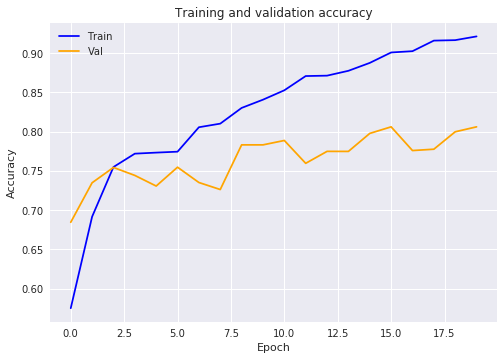

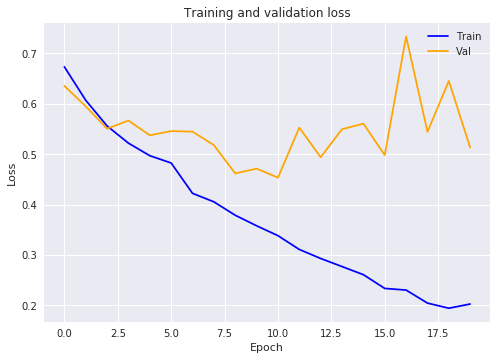

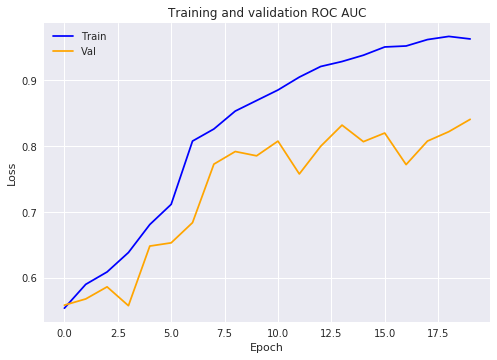

In [11]:
plot(history)   # default settings

Best ROC AUC 0.8408565677650215
Best Acc 0.8061403512954712
----Best Epoch:
train_loss    0.202535
valid_loss    0.513082
train_acc     0.921378
valid_acc     0.806140
train_roc     0.962840
roc           0.840857
Name: 19, dtype: float64
----


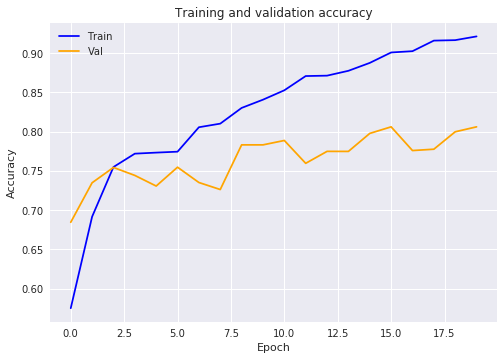

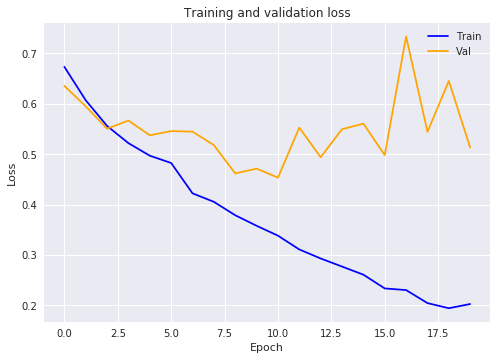

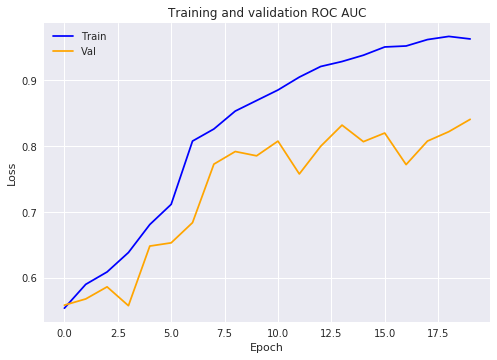

In [12]:
# hidR = 128 * 2, layerR = 1, hidC = 128 * 2, dropout = 0.5, l2 = 0.001
# ROC: 0.84904，0.85640, 0.85133
plot(history)
print("Best ROC AUC",history['roc'].max())
print("Best Acc", history['valid_acc'].max())
print("----Best Epoch:")
print(history.loc[history['roc'].idxmax(), :])
print("----")

Best ROC AUC 0.867899209780826
Best Acc 0.8314692974090576
----Best Epoch:
train_loss    0.194005
valid_loss    0.436638
train_acc     0.920777
valid_acc     0.831469
train_roc     0.966008
roc           0.867899
Name: 11, dtype: float64
----


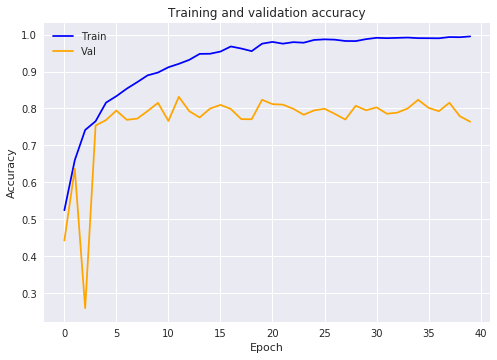

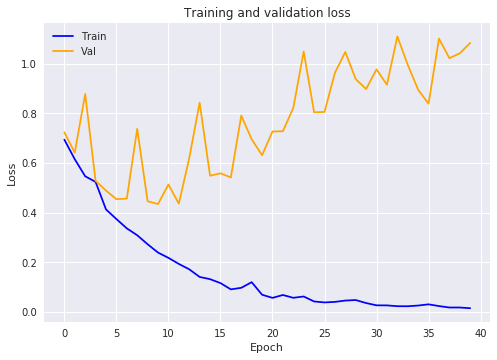

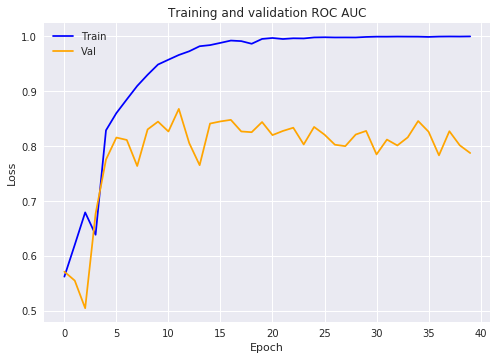

In [25]:
# hidR = 128 * 2, layerR = 1, hidC = 128 * 2, dropout = 0.5
# ROC: 0.842, 0.8512, 0.85453, 0.86790
plot(history)
print("Best ROC AUC",history['roc'].max())
print("Best Acc", history['valid_acc'].max())
print("----Best Epoch:")
print(history.loc[history['valid_acc'].idxmax(), :])
print("----")

In [12]:
plt.style.use('seaborn')

Best ROC AUC 0.8430806122956115
Best Acc 0.8300986846288045


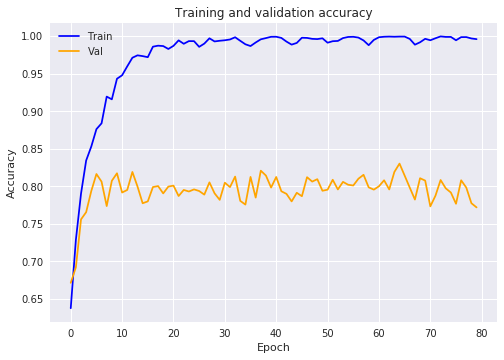

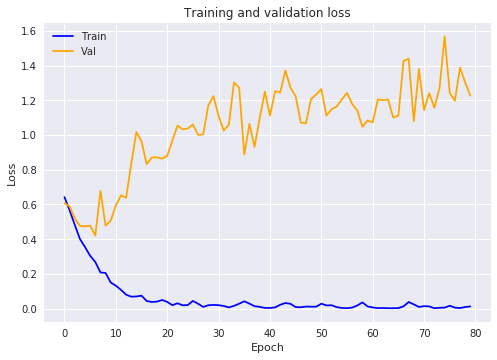

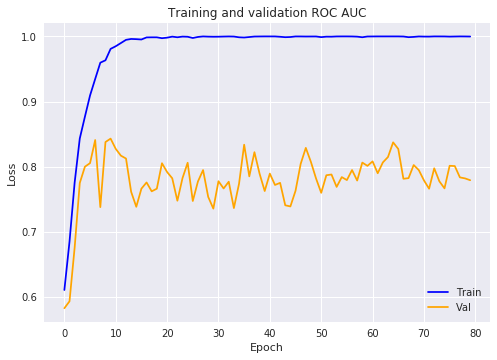

In [17]:
# hidR = 128 * 2, layerR = 1, hidC = 128 * 2
plot(history)
print("Best ROC AUC",history['roc'].max())
print("Best Acc", history['valid_acc'].max())

Best ROC AUC 0.8140189354405845
Best Acc 0.8138157884279887


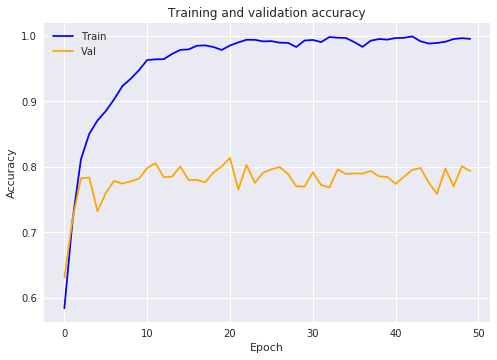

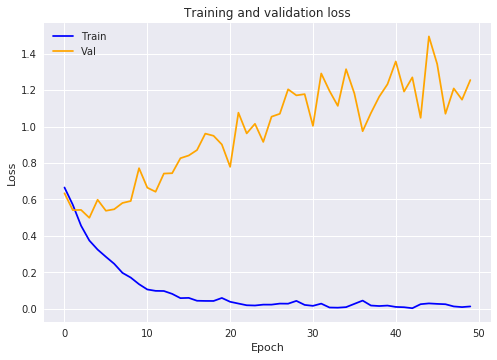

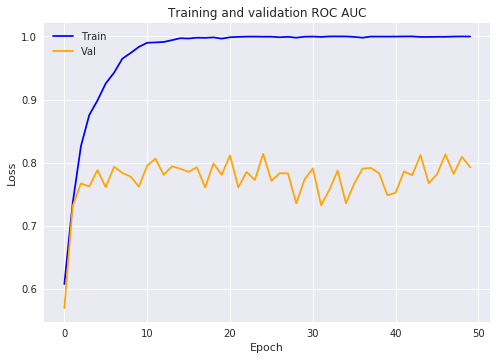

In [35]:
# hidR = 128 * 2, layerR = 1, hidC = 128 * 4
plot(history)
print("Best ROC AUC",history['roc'].max())
print("Best Acc", history['valid_acc'].max())

Best ROC AUC 0.8424904328810694
Best Acc 0.8081688602765401
----Best Epoch:
train_loss    0.097451
valid_loss    0.637533
train_acc     0.963188
valid_acc     0.808169
train_roc     0.991423
roc           0.834837
Name: 38, dtype: float64
----


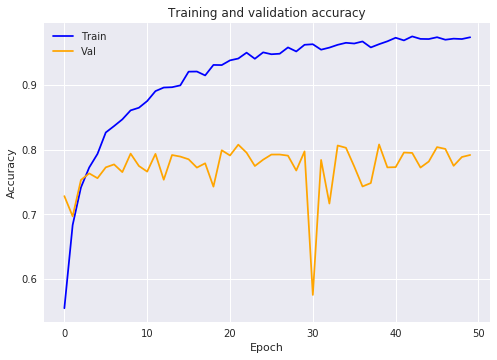

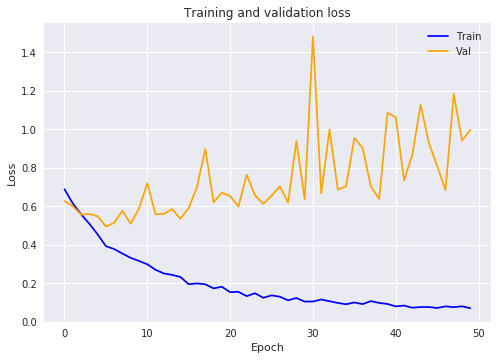

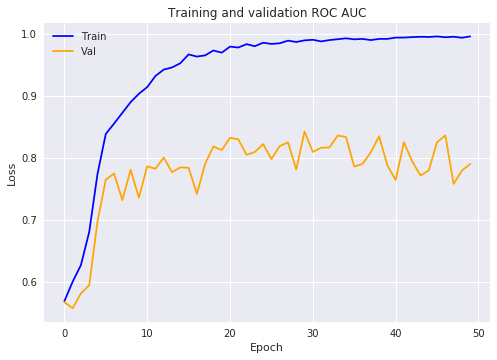

In [13]:
# LSTM
# hidR = 128 * 2, layerR = 1, hidC = 128 * 2, dropout = 0.5
# 0.8030602355747727
# Best Acc 0.7956688602765402

plot(history)
print("Best ROC AUC",history['roc'].max())
print("Best Acc", history['valid_acc'].max())
print("----Best Epoch:")
print(history.loc[history['valid_acc'].idxmax(), :])
print("----")